In [ ]:
from typing import TypedDict, Annotated
from langgraph.graph.message import AnyMessage, add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    status: False 

In [15]:
from pydantic import BaseModel, Field
from typing import Literal

class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    tool: Literal["reservation_assistant", "rag_assistant", "terminate"] = Field(
        ...,
        description="Given a user question choose to route it to reservation_assistant or rag_assistant or terminate",
    )

In [16]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

route_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert at routing a user question to a reservation_assistant, rag_assistant and terminate.
            The reservation_assistant is responsible for canceling and changing(updating) reservation.
            The rag_assistant is responsible for finding information and adding new reservation.
            Use the reservation_assistant and rag_assistant about reservation. Otherwise, select terminate.""",
        ),
        ("human", "{messages}"),
    ]
)

model = ChatOpenAI(model="gpt-4o-mini")
structured_model = model.with_structured_output(RouteQuery)

router_runnable = route_prompt | structured_model 

def terminate_agent():
    print("AI Agent Terminate!")

def route_question_adaptive(state: State) -> Literal["reservation_assistant", "rag_assistant", "terminate"]:
    latest_message = state["messages"]
    try:
        result = router_runnable.invoke({"messages": latest_message})

        datasource = result.tool

        if datasource == "reservation_assistant":
            return "reservation_assistant"
        elif datasource == "rag_assistant":
            return "rag_assistant"
        else:
            return "terminate"
    except Exception as e:
        return "terminate"

In [39]:
def reservation_assistant(state: State) -> State:
    print("reservation_assistant")
    return {"status": True}
    # return {"messages": [{"AIMessage": "reservation_assistant"}]}

def rag_assistant(state: State) -> State:
    print("rag_assistant")
    return {"status": True}
    # return {"messages": [{"AIMessage": "rag_assistant"}]}

def terminate(state: State) -> State:
    print("terminate")
    return {"status": True}
    # return {"messages": [{"AIMessage": "terminate"}]}


In [40]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

builder = StateGraph(State)

builder.add_node("reservation_assistant", reservation_assistant)
builder.add_node("rag_assistant", rag_assistant)
builder.add_node("terminate", terminate)

builder.add_conditional_edges(
    START,
    route_question_adaptive
)
builder.add_edge("reservation_assistant", END)
builder.add_edge("rag_assistant", END)
builder.add_edge("terminate", END)

graph = builder.compile()

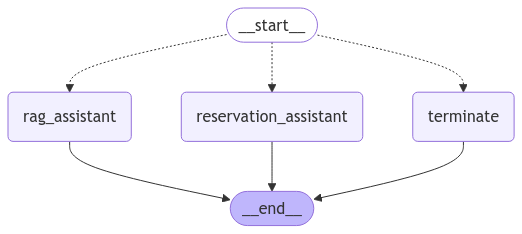

In [20]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [41]:
def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [44]:
inputs = input("질문해주세요.")

_printed = set()
for event in graph.stream({"messages": inputs}):
    _print_event(event, _printed)

rag_assistant


InvalidUpdateError: Expected node rag_assistant to update at least one of ['messages'], got {'status': True}